# Homework 1 Group A2

## FINM 37400 - 2024

### UChicago Financial Mathematics
10th January 2024
* Mark Hendricks
* hendricks@uchicago.edu

This homework relies on the data file, `treasury_quotes_2023-07-26`.

#### Nominal Securities
The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.


#### More Info
Find more info about many of the fields in the data set at the following link,

https://www.crsp.org/products/documentation/treasno-properties

Find the complete manual for the CRSP Treasury data at the following link,

https://www.crsp.org/files/treasury_guide_0.pdf

In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt

# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

Report the summary statistics of these time-to-maturities. Consider using `.describe()`.

In [2]:
rawdata = pd.read_excel("treasury_quotes_2023-07-26.xlsx",sheet_name='quotes')
quote_date = pd.to_datetime("2023-07-26")
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

rawdata = rawdata[rawdata['ITYPE']!=11]
rawdata = rawdata[rawdata['ITYPE']!=12]

series = (rawdata['TMATDT'].apply(lambda x: x.timestamp()) - rawdata['CALDT'].apply(lambda x: x.timestamp()))/(3600*24*365.25)
TTM = pd.DataFrame(series,columns=['Time to maturity in years'])

TTM.describe()

,Time to maturity in years
count,386.000000
mean,6.260656
std,8.004002
min,0.002738
25%,0.900068
50%,2.825462
75%,6.549624
max,29.637235


## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

We will discuss this adjustment for accrued interest later. For now, simply adjust as described in the formula.

In [3]:
price_series = (rawdata['TDBID']+rawdata['TDASK'])/2 + rawdata['TDACCINT']

prices = pd.DataFrame(price_series,columns=['Dirty Price'])

prices.describe()

,Dirty Price
count,386.000000
mean,94.295832
std,8.861478
min,55.518003
25%,90.442515
50%,96.725210
75%,99.163511
max,114.621264


## 3 YTM

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

In [4]:
from scipy.optimize import fsolve
import math

def get_ytm(price,coupon,ttm,freq=2):
    def obj_func(ytm):    
        disc_sums = 0
        num_cashflows = math.ceil(freq*ttm)
        if(num_cashflows==1):
            eq = price - (100+coupon/freq)/(math.pow((1+ytm/freq),freq*ttm))
        
        else:    
            for i in range(1,num_cashflows):
                disc_sums += (coupon/freq)/(math.pow((1+ytm/freq),(freq*ttm-i)))
            eq = price - disc_sums - (100+coupon/freq)/(math.pow((1+ytm/freq),freq*ttm))
    
        return eq
    return fsolve(obj_func,0.1)[0]/365.25        
        

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [5]:
processed_data = pd.DataFrame()
processed_data['maturity'] =  TTM['Time to maturity in years']
processed_data['price'] = prices['Dirty Price']
processed_data['coupon rate'] = rawdata['TCOUPRT']

processed_data['ytm'] = processed_data.apply(lambda x: get_ytm(x['price'], x['coupon rate'], x['maturity']), axis=1)
processed_data['TDYLD'] = rawdata['TDYLD']
processed_data['bid-ask'] = rawdata['TDASK']-rawdata['TDBID']

processed_data.head()

,maturity,price,coupon rate,ytm,TDYLD,bid-ask
KYTREASNO,,,,,,
207997,0.002738,99.986111,0.000,0.000141,0.000139,0.000028
207231,0.013689,101.337017,2.750,0.000075,0.000075,0.031250
207742,0.013689,100.017805,0.125,0.000090,0.000089,0.039062
206998,0.013689,100.564766,1.250,0.000121,0.000120,0.039062
208025,0.016427,99.915000,0.000,0.000144,0.000142,0.000167


In [6]:
processed_data.describe()

,maturity,price,coupon rate,ytm,TDYLD,bid-ask
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,6.260656,94.295832,2.182642,0.000127,0.000126,0.036619
std,8.004002,8.861478,1.634226,0.000016,0.000015,0.018396
min,0.002738,55.518003,0.000000,0.000075,0.000075,0.000028
25%,0.900068,90.442515,0.750000,0.000113,0.000112,0.031250
50%,2.825462,96.725210,2.250000,0.000123,0.000122,0.031250
75%,6.549624,99.163511,3.125000,0.000144,0.000142,0.046875
max,29.637235,114.621264,7.625000,0.000167,0.000149,0.093750


## 4 Plots

Create scatter plots of...
* maturity versus price for all issues.
* maturity versus YTM for all issues.

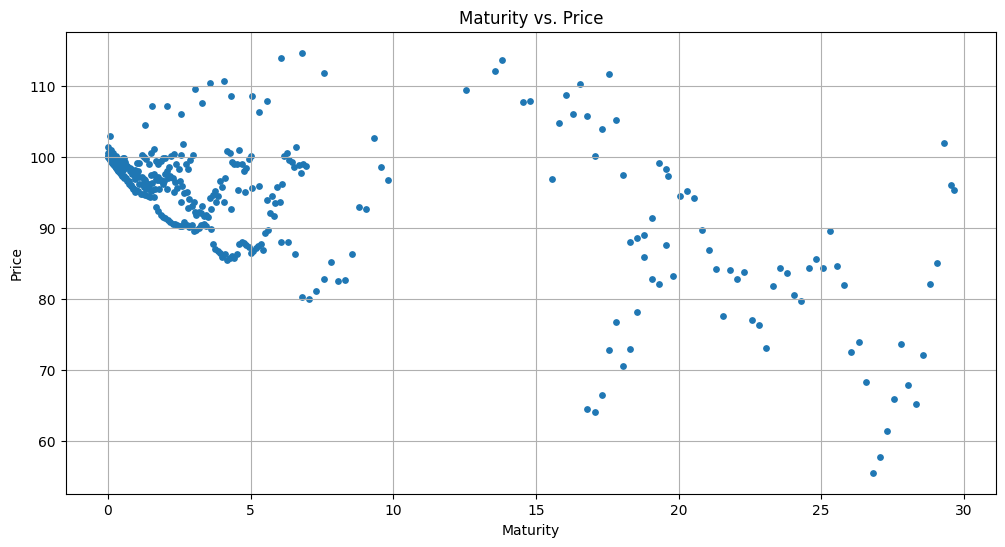

In [7]:
import matplotlib.pyplot as plt

# Scatter plot of maturity versus price
plt.figure(figsize=(12, 6))
plt.scatter(processed_data['maturity'], processed_data['price'], marker='o',s=15)
plt.title('Maturity vs. Price')
plt.xlabel('Maturity')
plt.ylabel('Price')
plt.grid(True)
plt.show()

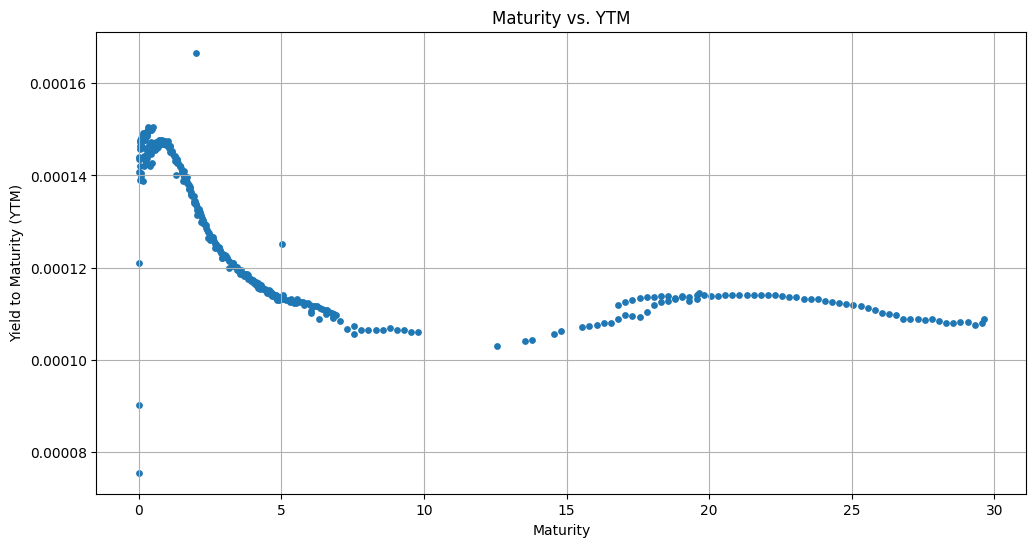

In [8]:
# Scatter plot of maturity versus YTM
plt.figure(figsize=(12, 6))
plt.scatter(processed_data['maturity'], processed_data['ytm'], marker='o',s=15)
plt.title('Maturity vs. YTM')
plt.xlabel('Maturity')
plt.ylabel('Yield to Maturity (YTM)')
plt.grid(True)
plt.show()

## 5 Bad Data?

Find the issues where `TDYLD` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

In [9]:
filtered_df = processed_data[processed_data['TDYLD'].isna()]
print(filtered_df)

Empty DataFrame
Columns: [maturity, price, coupon rate, ytm, TDYLD, bid-ask]
Index: []


# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [10]:
processed_data['Maturity Date'] = rawdata['TMATDT']

cashflow_mat = pd.DataFrame()
cashflow_mat.index.name = 'KYTREASNO'

for i,r in processed_data.iterrows():
    maturity = r['Maturity Date']
    di = {}
    di[maturity] = 100+r['coupon rate']/2
    cur_date = maturity - pd.DateOffset(months=6)
    while(cur_date>quote_date):
        di[cur_date] = r['coupon rate']/2
        cur_date = cur_date - pd.DateOffset(months=6)

    temp_df = pd.DataFrame.from_dict([di])
    temp_df.index = [i]
    cashflow_mat = pd.concat([cashflow_mat,temp_df],axis=0)

cashflow_mat = cashflow_mat.fillna(0)

In [11]:
display(cashflow_mat)

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
207997,100.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
207231,0.0,101.3750,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
207742,0.0,100.0625,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
206998,0.0,100.6250,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
208025,0.0,0.0000,100.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207891,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0000,1.4375,0.0000,0.0000,101.4375,0.0000,0.0000,0.0,0.0000,0.0000
207934,0.0,0.0000,0.0,0.0,0.0,0.0,1.5000,0.0,0.0,0.0,...,0.0000,0.0000,1.5000,0.0000,0.0000,101.5000,0.0000,0.0,0.0000,0.0000
207977,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,102.0,0.0000,0.0000
208019,0.0,0.0000,0.0,0.0,0.0,0.0,1.8125,0.0,0.0,0.0,...,0.0000,0.0000,1.8125,0.0000,0.0000,1.8125,0.0000,0.0,101.8125,0.0000


In [12]:
max_cashflow = pd.DataFrame(columns=['Time with most Cashflow','Cashflow'])
max_cashflow['Time with most Cashflow'] = [cashflow_mat.sum().idxmax()]
max_cashflow['Cashflow'] = [cashflow_mat[cashflow_mat.sum().idxmax()].sum()]
max_cashflow.set_index('Time with most Cashflow',inplace=True)
max_cashflow

,Cashflow
Time with most Cashflow,
2023-08-15,517.6875


In [13]:
most_issues = pd.DataFrame(columns=['Time with most issues paying','Number of issues paying'])

most_issues_column = cashflow_mat.apply(lambda col: col[col != 0].count()).idxmax()
num_issues = cashflow_mat[most_issues_column][cashflow_mat[most_issues_column] != 0].count()

most_issues['Time with most issues paying'] = [most_issues_column]
most_issues['Number of issues paying'] = [num_issues]
most_issues.set_index('Time with most issues paying',inplace=True)

most_issues

,Number of issues paying
Time with most issues paying,
2023-08-15,76


## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing on that date.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

In [14]:
cashflow_bootstrap = cashflow_mat.copy()

#Choose the security which has a smaller bid-ask if they have the same maturity and discard the others
for col,data in cashflow_bootstrap.iteritems():
    for j in range(len(data.index)):
        min_bid_ask = 1
        if(data.iloc[j]>=100 and processed_data.loc[data.index[j],'bid-ask'] <=min_bid_ask):
            ind = j
            min_bid_ask = processed_data.loc[data.index[j],'bid-ask']

    for j in range(len(data.index)):
        if(data.iloc[j]>=100):
            if(j!=ind):
                cashflow_bootstrap = cashflow_bootstrap.drop(data.index[j])
                


In [15]:
#Remove Columns which do not have any security maturing
for col,data in cashflow_bootstrap.iteritems():
    flag = 0    
    for j in range(len(data.index)):
        if(data.iloc[j]>=100):
            flag = 1
            break

    if(flag==0):
        del cashflow_bootstrap[col]
    

In [16]:
#Make the prices vector with the same securities
prices_bootstrap = prices.copy()
prices_bootstrap = pd.DataFrame({'Dirty Price':prices_bootstrap['Dirty Price'][cashflow_bootstrap.index]})

In [17]:
def get_ttm_in_years(cashflow_cols,quote_date):
    ttm = np.zeros(len(cashflow_cols))

    for i in range(len(ttm)):
        ttm[i] = (cashflow_cols[i].timestamp()-quote_date.timestamp())/(3600*24*362.25)

    return ttm    

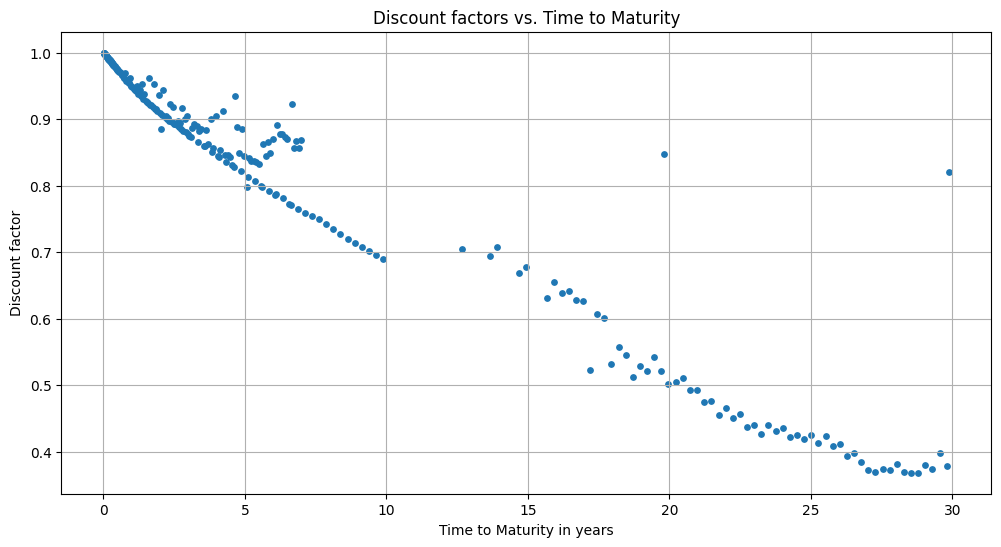

In [18]:
p = prices_bootstrap.values
C = cashflow_bootstrap.values

discount_factors = np.linalg.solve(C,p)
ttm = get_ttm_in_years(cashflow_bootstrap.columns,quote_date)

plt.figure(figsize=(12, 6))
plt.scatter(ttm,discount_factors, marker='o',s=15)
plt.title('Discount factors vs. Time to Maturity')
plt.xlabel('Time to Maturity in years')
plt.ylabel('Discount factor')
plt.grid(True)
plt.show()

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

In [19]:
cashflow_valid = cashflow_mat.copy()
#Making a valid cashflow matrix which has atleast one maturity for every date
for col,data in cashflow_valid.iteritems():
    flag = 0    
    for j in range(len(data.index)):
        if(data.iloc[j]>=100):
            flag = 1
            break

    if(flag==0):
        del cashflow_valid[col]


In [20]:
#Remove securities which do not have a maturity
for i,r in cashflow_valid.iterrows():
    flag = 0    
    for j in range(len(r)):
        if(r.iloc[j]>=100):
            flag = 1
            break
    if(flag==0):
        cashflow_valid.drop(i)

In [21]:
#Accordingly make the prices vector for OLS
prices_valid = prices.copy()
prices_valid['Dirty Price'] = prices_valid['Dirty Price'][cashflow_valid.index]

In [22]:
import statsmodels.api as sm

y = prices_valid.values
X = cashflow_valid.values

model = sm.OLS(y,X).fit()


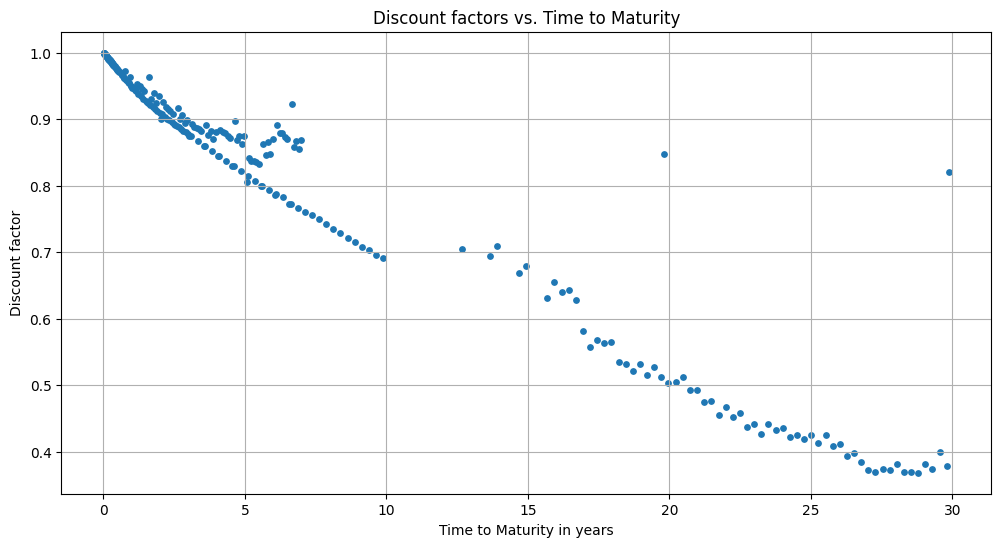

In [23]:
discount_factors_OLS = model.params
ttm2 = get_ttm_in_years(cashflow_valid.columns,quote_date)

plt.figure(figsize=(12, 6))
plt.scatter(ttm2,discount_factors_OLS, marker='o',s=15)
plt.title('Discount factors vs. Time to Maturity')
plt.xlabel('Time to Maturity in years')
plt.ylabel('Discount factor')
plt.grid(True)
plt.show()

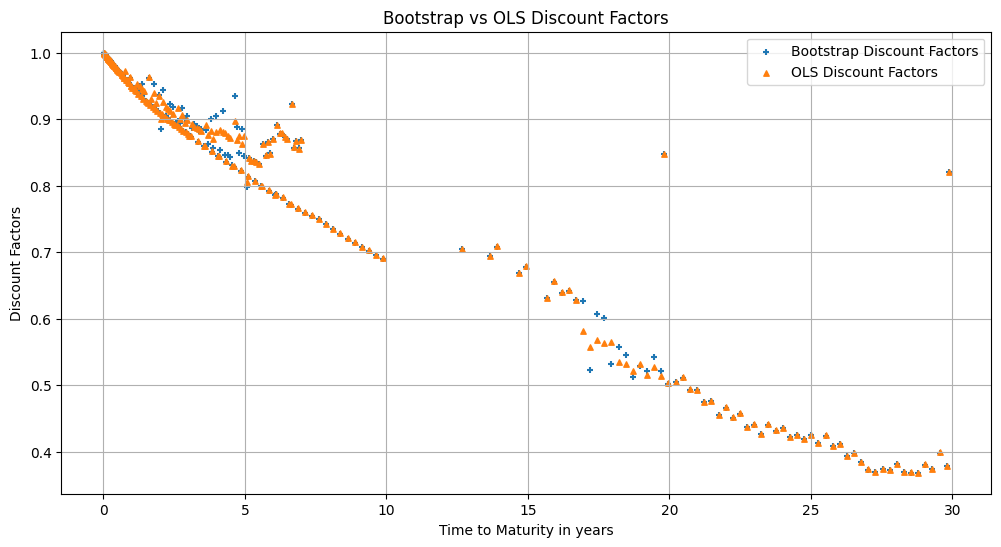

In [24]:
#Plot them together to see a comparison
plt.figure(figsize=(12, 6))
plt.scatter(ttm, discount_factors,marker='+',s=15, label='Bootstrap Discount Factors')
plt.scatter(ttm2, discount_factors_OLS,marker='^',s=15, label='OLS Discount Factors')

plt.xlabel('Time to Maturity in years')
plt.ylabel('Discount Factors')
plt.title('Bootstrap vs OLS Discount Factors')
plt.grid(True)
plt.legend()
plt.show()

## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

In [25]:
discount_rate_cont = np.zeros(len(discount_factors))
discount_rate_semi_annual = np.zeros(len(discount_factors))

for i in range(len(discount_factors)):
    discount_rate_cont[i] = -math.log(discount_factors[i])/(ttm[i])
    discount_rate_semi_annual[i] = 2*(math.exp(discount_rate_cont[i]/2)-1)

discount_rate_cont_OLS = np.zeros(len(discount_factors_OLS))
discount_rate_semi_annual_OLS = np.zeros(len(discount_factors_OLS))

for i in range(len(discount_factors_OLS)):
    discount_rate_cont_OLS[i] = -math.log(discount_factors_OLS[i])/(ttm2[i])
    discount_rate_semi_annual_OLS[i] = 2*(math.exp(discount_rate_cont_OLS[i]/2)-1)


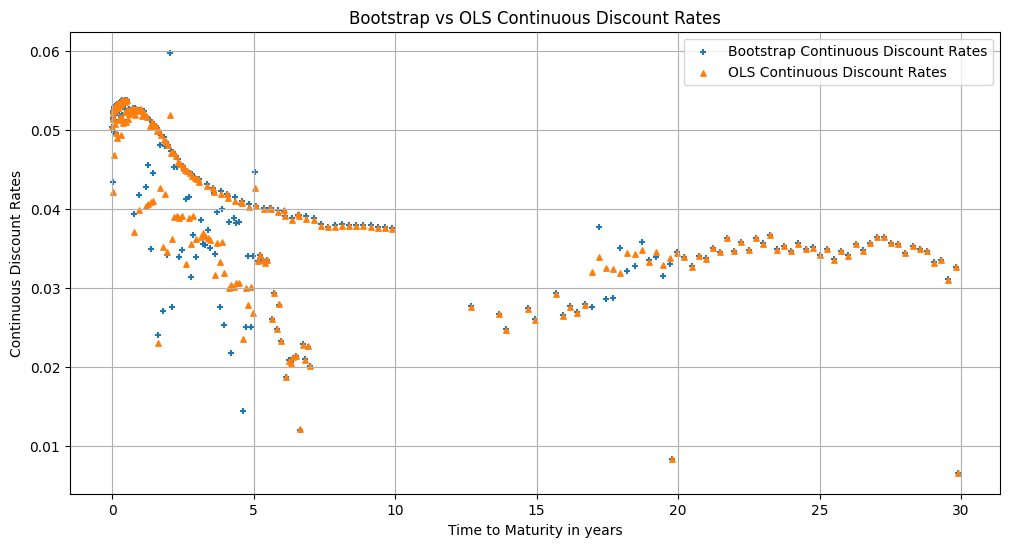

In [26]:
plt.figure(figsize=(12, 6))
plt.scatter(ttm, discount_rate_cont,marker='+',s=15, label='Bootstrap Continuous Discount Rates')
plt.scatter(ttm2, discount_rate_cont_OLS,marker='^',s=15, label='OLS Continuous Discount Rates')

plt.xlabel('Time to Maturity in years')
plt.ylabel('Continuous Discount Rates')
plt.title('Bootstrap vs OLS Continuous Discount Rates')
plt.grid(True)
plt.legend()
plt.show()

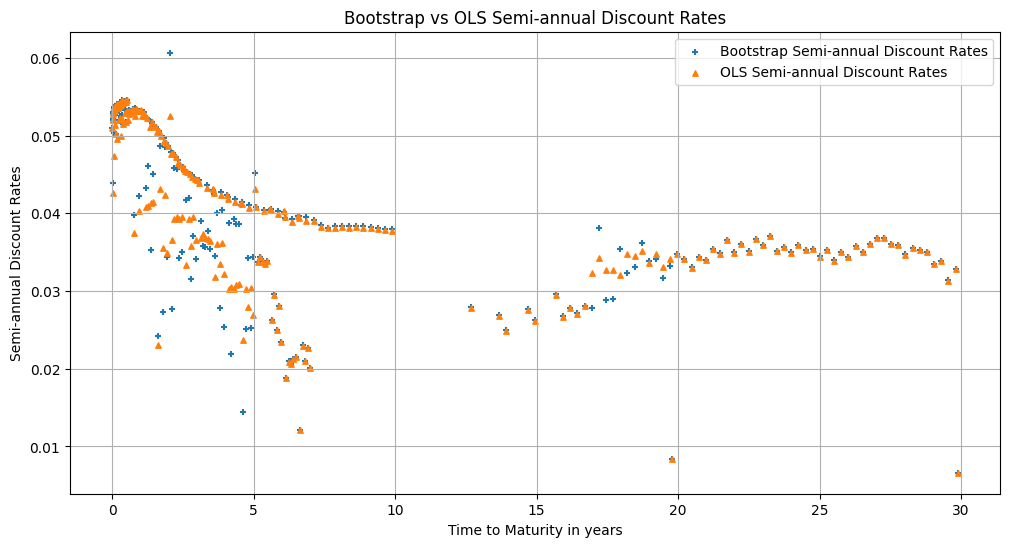

In [27]:
plt.figure(figsize=(12, 6))
plt.scatter(ttm, discount_rate_semi_annual,marker='+',s=15, label='Bootstrap Semi-annual Discount Rates')
plt.scatter(ttm2, discount_rate_semi_annual_OLS,marker='^',s=15, label='OLS Semi-annual Discount Rates')

plt.xlabel('Time to Maturity in years')
plt.ylabel('Semi-annual Discount Rates')
plt.title('Bootstrap vs OLS Semi-annual Discount Rates')
plt.grid(True)
plt.legend()
plt.show()

***

# Problem 3: Nelson-Siegel Curve

Use the Nelson-Siegel curve to model the discount rates. 

Fit them via minimizing the sum of squared errors for the prices imputed by the model versus the quoted prices. 

Consider using `minimize` from `scipy.optimize`.

* Estimate the model three times, using $\textbf{C}$, $\tilde{\textbf{C}}$, $\hat{\textbf{C}}$.

* Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

* Also plot the associated continuously-compounded discount rates.

$\begin{align}
r(t,T) =& f(T-t,\boldsymbol{\theta})\\
=& \theta_0 + (\theta_1 + \theta_2)\frac{1-e^{-T/\lambda}}{T/\lambda} - \theta_2 e^{-T/\lambda}
\end{align}
$

In [28]:
def estimate_ns(params, *args):
    t0, t1, t2, y = params[0], params[1], params[2], params[3]

    prices = args[0]
    cashflow = args[1]
    
    error=0
    for i in cashflow.index:
        price=0
        for ii in cashflow.loc[i][cashflow.loc[i]>0].index:
            rate = t0+((t1+t2)*((1-math.exp(-ii/y))/(ii/y)))-t2*math.exp(-ii/y)
            price += cashflow.loc[i,ii]*math.exp(-rate*ii)
            
        error += (price-prices.loc[i,'Dirty Price'])**2
    return error


In [29]:
from scipy.optimize import minimize

cashflow = cashflow_mat.copy()
cashflow.columns = get_ttm_in_years(cashflow.columns,quote_date)

NS_C = minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(prices, cashflow), method='L-BFGS-B')


In [30]:
cashflow = cashflow_bootstrap.copy()
cashflow.columns = get_ttm_in_years(cashflow.columns,quote_date)

NS_Cbootstrap = minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(prices_bootstrap, cashflow), method='L-BFGS-B')

In [31]:
cashflow = cashflow_valid.copy()
cashflow.columns = get_ttm_in_years(cashflow.columns,quote_date)

NS_COLS = minimize(estimate_ns, [0.01, 0.01, 0.01, 1], args=(prices_valid, cashflow), method='L-BFGS-B')


In [32]:
di = {}
di['\u03B8\u2080'] = [NS_C.x[0],NS_Cbootstrap.x[0],NS_COLS.x[0]]
di['\u03B8\u2081'] = [NS_C.x[1],NS_Cbootstrap.x[1],NS_COLS.x[1]]
di['\u03B8\u2082'] = [NS_C.x[2],NS_Cbootstrap.x[2],NS_COLS.x[2]]
di['\u03BB'] = [NS_C.x[3],NS_Cbootstrap.x[3],NS_COLS.x[3]]

NS = pd.DataFrame(di,columns=['\u03B8\u2080','\u03B8\u2081','\u03B8\u2082','\u03BB'])
NS.index.name = 'Nelson-Siegel'
NS.index = ['Complete Data','Bootstrap Data','OLS Data']

NS

,θ₀,θ₁,θ₂,λ
Complete Data,0.041196,0.020554,-0.032475,2.458203
Bootstrap Data,0.035796,0.024875,-0.045876,2.871759
OLS Data,0.034905,0.024171,-0.038543,2.553204


In [33]:
def get_rate_discount_factor(cashflow,quote_date,NS_x):
    discount_factors = np.zeros(len(cashflow.columns))
    rates = np.zeros(len(cashflow.columns))
    ttm = get_ttm_in_years(cashflow.columns,quote_date)

    for i in range(len(discount_factors)):
        rates[i] = NS_x[0] + (NS_x[1]+NS_x[2])*(1-math.exp(-ttm[i]/NS_x[3]))/(ttm[i]/NS_x[3]) - NS_x[2]*math.exp(-ttm[i]/NS_x[3])
        discount_factors[i] = math.exp(-rates[i]*ttm[i])

    return ttm, rates, discount_factors    

In [34]:
ttm, rates, discount_factors = get_rate_discount_factor(cashflow_mat,quote_date,NS_C.x)    
ttm_bootstrap, rates_bootstrap, discount_factors_bootstrap = get_rate_discount_factor(cashflow_bootstrap,quote_date,NS_Cbootstrap.x)
ttm_OLS, rates_OLS, discount_factors_OLS = get_rate_discount_factor(cashflow_valid,quote_date,NS_COLS.x)    


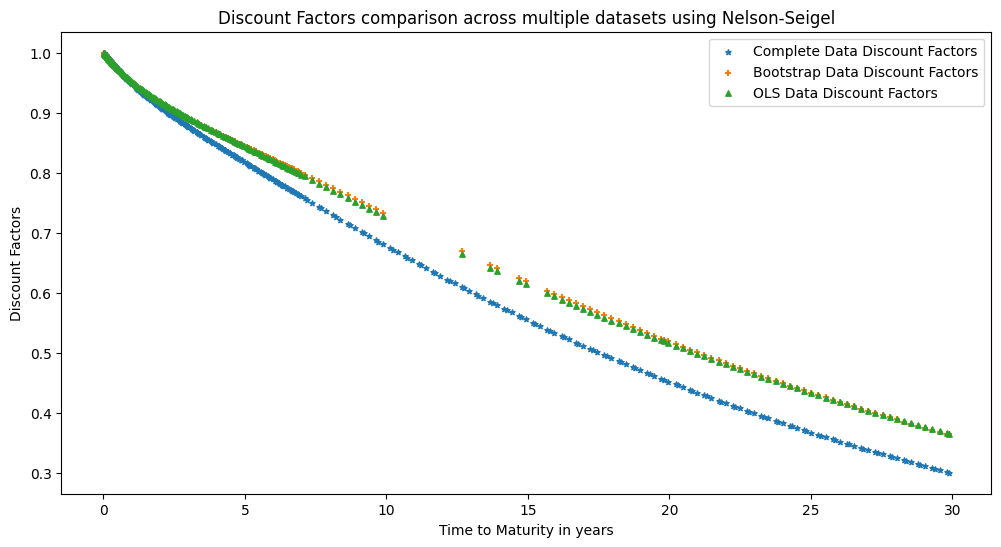

In [35]:
plt.figure(figsize=(12, 6))
plt.scatter(ttm, discount_factors,marker='*',s=15, label='Complete Data Discount Factors')
plt.scatter(ttm_bootstrap, discount_factors_bootstrap,marker='+',s=15, label='Bootstrap Data Discount Factors')
plt.scatter(ttm_OLS, discount_factors_OLS,marker='^',s=15, label='OLS Data Discount Factors')

plt.xlabel('Time to Maturity in years')
plt.ylabel('Discount Factors')
plt.title('Discount Factors comparison across multiple datasets using Nelson-Seigel')

plt.legend()
plt.show()

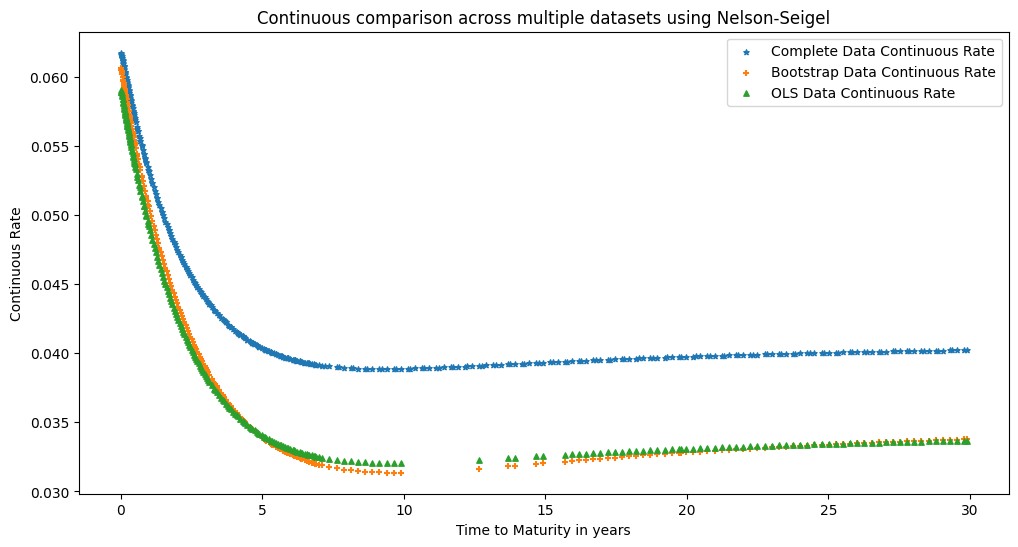

In [36]:
plt.figure(figsize=(12, 6))
plt.scatter(ttm, rates,marker='*', s=15, label='Complete Data Continuous Rate')
plt.scatter(ttm_bootstrap, rates_bootstrap,marker='+', s=15, label='Bootstrap Data Continuous Rate')
plt.scatter(ttm_OLS, rates_OLS,marker='^', s=15, label='OLS Data Continuous Rate')

plt.xlabel('Time to Maturity in years')
plt.ylabel('Continuous Rate')
plt.title('Continuous comparison across multiple datasets using Nelson-Seigel')

plt.legend()
plt.show()